# Network Analysis and Community Detection in Social Network Data
#### Prepared by: Jelo Delariarte, Elkan Pagobayan, Lennart Panton, Matmat Romero

Master of Science in Data Science 2021   
Asian Institute of Management

---

*All rights reserved. No part of this document may be reproduced or transmitted in any form or by any means, or stored in any retrieval system of any nature without prior written permission.*

© 2021

<div><span style="background-color: skyblue; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold"> EXECUTIVE SUMMARY </span></div>

This notebook presents an analysis of social network originating from the 1600's. Using `python` and `networkx`, the data is reconstructed into a graph then analyzed its' key characteristics. From the analysis...

<div><span style="background-color: skyblue; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold"> INTRODUCTION </span></div>

The science of analyzing social network may be attributed to one central concept -- social network analysis studies relationships and how it may (or may not) affect a network. Different factors like age, personality, external aesthetics, ethnicity, among others, affect different peoples' relationships. When these things come into play, it is natural for certain groups of people tend to group up together with whom they have more affinity with, forming clusters and communities within each network. 

Social Networks may also show highly-influential nodes which may be used to track flow of information. This type of insight may shed light on how certain phenomenons may play out like disease spreading and even something as mundane as trying to trace the spread of gossip.

For the given social network data, we will try to analyze the network by identifying basic statistics and performing exploratory analysis, with the intention of crafing a highly probable data story to describe the social network in question.

<div><span style="background-color: skyblue; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold"> METHODOLOGY </span></div>

This section provides an outline of the analysis methodology performed in this notebook - network visualization, EDA, community detection, computing centrality measures, hypothesis on the potential dynamics of the networks, and conclusion.

#### Network Visualization  
To understand the layout of the network, the topology is mapped via networkx. At the onset, it shows what type of relationships appear and initial conjectures about the network may be conceived just by looking at the initial network visualization.
  
#### Exploratory Data Analysis
Aside from utilizing networkx to check basic statistics on the data, more insights will be gethered via the Pandas library.   

#### Community Detection  
Groupings and clusters based on the relationships appear in social networks, so that fact will be investigated and will be analyzed.

#### Computing Centrality Measures*  
Essentially, centrality is measured in different methods to determine influential nodes in the networks. This is determined to understand the flow of information within the network. 

#### Hypothesis on the Potential Dynamic of the Network  
What type of social network is the dataset being analyzed? This question is the main focus of the said section and a qualitative analysis based on the insights gathered from the different network properties.

#### Conclusion  
A summary of findings and specific recommendations to improve the network is laid out in the conclusion section.


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import community
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial import distance
from collections import defaultdict

from wordcloud import WordCloud, STOPWORDS
sns.set(style="darkgrid", context="talk")

### Loading the Dataset
The social network dataset is initialized via pandas. The dataset pertains to two `.csv` files pertaining to the nodes with their targets and the node properties. 

In [2]:
df_edges = pd.read_csv('social_network_edges.csv')
df_nodes = pd.read_csv('social_network_nodes.csv')

In [3]:
display(df_edges.head())
print("Table 1 -  Nodes with their targets")
display(df_nodes.head())
print("Table 2 -  Node details with properties")

,Source,Target
0,Antonio Rutledge,Daniel Lopez
1,Antonio Rutledge,Jeffrey Jackson
2,Antonio Rutledge,Lieselotte Egan
3,Antonio Rutledge,Eric Hebb
4,Antonio Rutledge,James Cooks


Table 1 -  Nodes with their targets


,Name,Historical Role,Gender,Birth Year,Death Year
0,Robert Tanner,religious writer,male,1663,1731
1,Willie Schlater,local politician and author,male,1621,1694
2,Dan Jimenez,colonial official and scholar,male,1674,1751
3,Particia Turner,Community pastor,female,1656,1659
4,Thomas Boudreau,Community pastor and poet,male,1626,1697


Table 2 -  Node details with properties


### Creating the Network
The dataset with the nodes, targets, and properties are loaded into network `G` via networkx. Afterwards, the nodes' attributes are set to `G` as well. Basic statistics (Fig.1) and an example of a node with its properties (Fig.2) are shown below.

In [4]:
G = nx.Graph()
G = nx.from_pandas_edgelist(df_edges, 'Source', 'Target')

print('Number of people in the network:', len(G.nodes))
print('Links:', G.size())
print('\nFig.1 - Basic Statistics of the Network.')

Number of people in the network: 119
Links: 174

Fig.1 - Basic Statistics of the Network.


In [5]:
attr = df_nodes.set_index('Name').to_dict('index')
nx.set_node_attributes(G, attr)
display(G.nodes['Robert Tanner'])

print('\nFig.2 - 1 Node with Properties')

{'Historical Role': 'religious writer',
 'Gender': 'male',
 'Birth Year': 1663,
 'Death Year': 1731}


Fig.2 - 1 Node with Properties


<div><span style="background-color: skyblue; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold"> NETWORK VISUALIZATION </span></div>

The topology of the `G` is shown in this section. Since this is a social network where the flow of information between nodes is not unidirectional, `G` is reconstructed via an undirected graph to simulate interactions (talking, speaking) between the nodes.

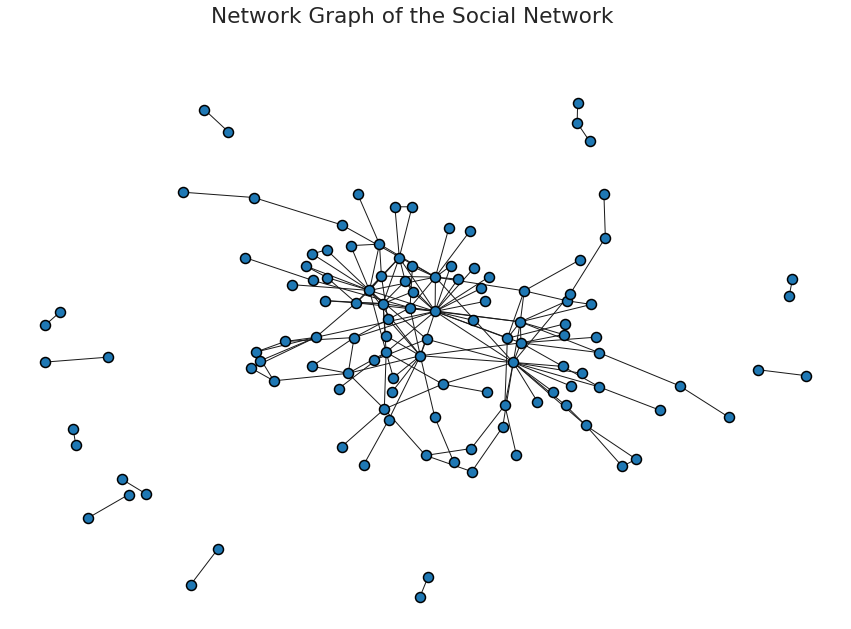

Fig 3 - Graphical Representation of the Social Network


In [6]:
plt.figure(figsize=(15,10))
plt.axis('off')

pos = nx.spring_layout(G, k=0.18)
nx.draw_networkx(G, pos = pos, cmap = plt.cm.RdYlBu, 
                node_size = 100, with_labels = False)

ax = plt.gca()
ax.collections[0].set_edgecolor("black")

plt.suptitle('Network Graph of the Social Network')
plt.show()
print('Fig 3 - Graphical Representation of the Social Network')

Immediately, `G` shows a giant component, while there are a couple of nodes that aren't connected to the giant component. The initial thought is that `G` might be a social network of a congregation of a big group or organization (social club, religious organization, etc) wherein all nodes are members, but not all know each other.

### Visualizing the Giant Component

Giant component is G0 with the following characteristics
Nodes: 96
Number of links: 162


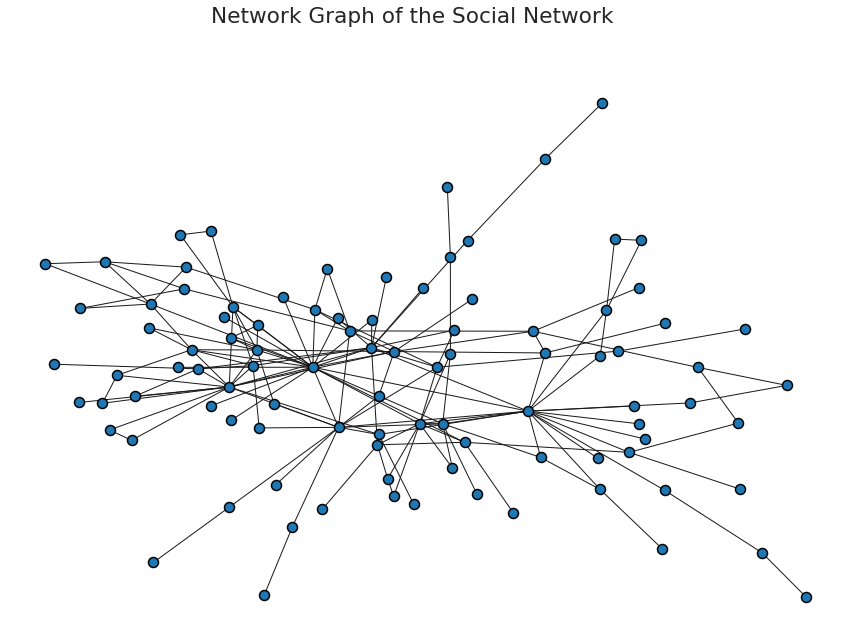

Fig 4 - The Giant Component


In [7]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

print('Giant component is G0 with the following characteristics')
print('Nodes:',len(G0.nodes()))
print('Number of links:', G0.size())


plt.figure(figsize=(15,10))
plt.axis('off')

pos = nx.spring_layout(G0, k=0.18)
nx.draw_networkx(G0, pos = pos, cmap = plt.cm.RdYlBu, 
                node_size = 100, with_labels = False)

ax = plt.gca()
ax.collections[0].set_edgecolor("black")

plt.suptitle('Network Graph of the Social Network')
plt.show()
print('Fig 4 - The Giant Component')

The giant component has at least 96 nodes, and upon closer inpection, there are nodes that appear to be centers of the giant component. These might be the influential people in the group. This will be investigated later via centrality measures.

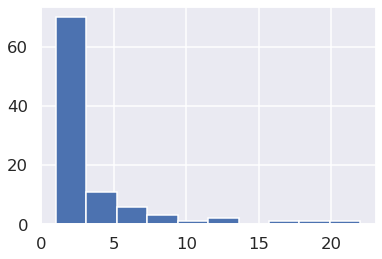

0.22689383308513314


3.3789473684210525

In [9]:
#Degree Distribution of Giant Component
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

plot_degree_dist(G0)

#Clustering Coefficient
cc = nx.clustering(G)
avg_clust = sum(cc.values()) / len(cc)
print(avg_clust)

#Characteristic Path Length
print(nx.average_shortest_path_length(G0))

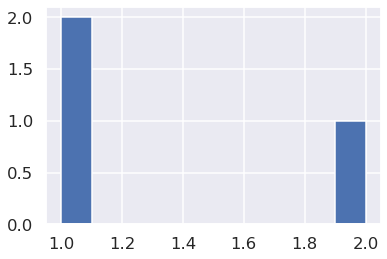

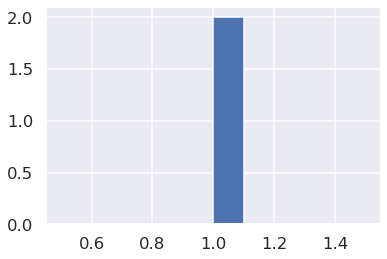

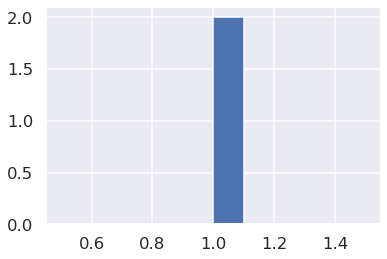

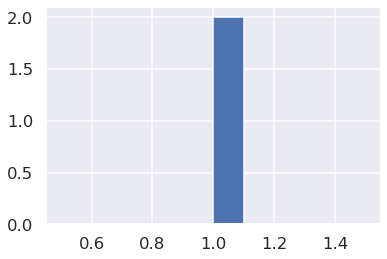

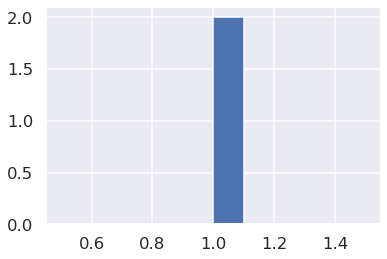

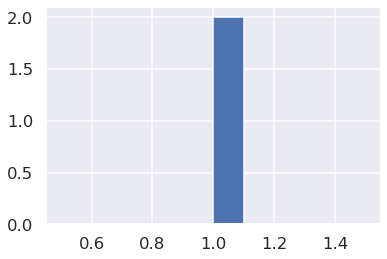

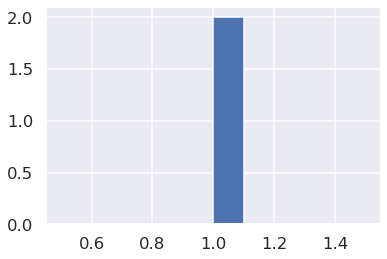

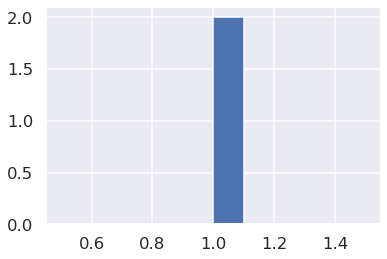

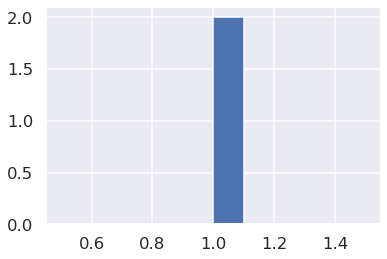

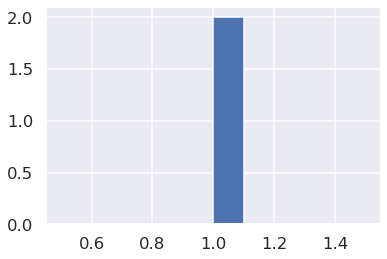

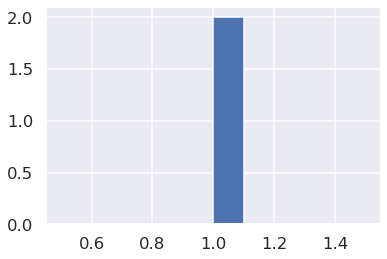

In [10]:
ext = [i for i in Gcc[1:]]
subs = [G.subgraph(ext[i]) for i in range(len(ext))]
for i in range(11):
    plot_degree_dist(subs[i])

{'Robert Maldonado', 'Robert Slover', 'Thomas Hanson'}
{'Willie Schlater', 'Thomas Boudreau'}
{'Walter Harrison', 'Daniel Williams'}
{'Lisa Hastings', 'Stacy Mayer'}
{'Gertrude Wright', 'Sharon Dalton'}
{'David Deason', 'Kenneth Giles'}
{'Emil Wood', 'Steven Balistrieri'}
{'Christopher Roberts', 'Gerardo Williams'}
{'Elizabeth Moore', 'Sherri Anderson'}
{'Brittney Gregory', 'Benjamin Sanchez'}
{'Gary Delvalle', 'George Ziemba'}


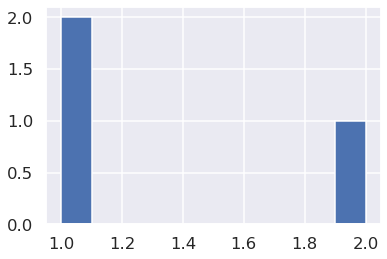

In [53]:
plot_degree_dist(G1)

[{'Robert Maldonado', 'Robert Slover', 'Thomas Hanson'},
 {'Thomas Boudreau', 'Willie Schlater'},
 {'Daniel Williams', 'Walter Harrison'},
 {'Lisa Hastings', 'Stacy Mayer'},
 {'Gertrude Wright', 'Sharon Dalton'},
 {'David Deason', 'Kenneth Giles'},
 {'Emil Wood', 'Steven Balistrieri'},
 {'Christopher Roberts', 'Gerardo Williams'},
 {'Elizabeth Moore', 'Sherri Anderson'},
 {'Benjamin Sanchez', 'Brittney Gregory'},
 {'Gary Delvalle', 'George Ziemba'}]

In [ ]:
print (list(nx.connected_components(G)))

<div><span style="background-color: skyblue; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold"> EXPLORATORY DATA ANALYSIS </span></div>

To further gather insights, EDA is performed on the network properties in a graphical manner via univariate analysis. The EDA is performed via the following python codes below.

#### Gender Distribution

In [ ]:
explode = (0.1, 0.1)

plt.pie(df_nodes.Gender.value_counts(), startangle=90, explode = explode,
            wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%', shadow=True,
       colors=['#e11900', '#7e00bf']);
plt.title('Gender Distribution', fontweight='bold')
plt.show();
print('Fig.4 - Distribution of Males and Females in the Dataset')

The dataset contains a significant amount of `male` individuals. If this is a social function, it would make sense that there are more males than females as in the sixteenth century, society favored men, so most women are at home tending to household matters. One such society that exhibited this behavior in the 16th to the 17th century is Europe during the renaissance period. This network then may be gathered from a european community.

#### Age Distribution

In [ ]:
plt.figure(figsize=(15,8))
df_nodes['Birth Year'].plot(kind='kde')
df_nodes['Death Year'].plot(kind='kde', color='red')
plt.legend()
plt.show()
print('Fig.5 Age Distribution of Nodes in the Dataset')

Most nodes were born around the 1600 - 1650's. Given that most year of deaths were around 1670 - 1700's, it can be inferred the nodes are late teens to adults. Age may factor in the relationships formed within the network so this is important to understand. If the dataset is indeed a club/congregation, more nodes of the same age may be closer together.

#### Age Distribution

In [ ]:
roles = [str(i).lower() for i in df_nodes['Historical Role'].values]

str_roles = ' '.join(roles)        
str_roles = ' '.join([i for i in str_roles.split() if i != 'community'])

plt.figure(figsize = (15, 8), facecolor = None) 
wordcloud = WordCloud(random_state=60, 
                      background_color='salmon', 
                      colormap='Pastel1', 
                      collocations=False, 
                      stopwords = None).generate(str_roles)

plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 
print('Fig 6. Wordcloud to show most common careers in the dataset')

This wordcloud somehow proves that the network is indeed a religious gathering. However, it wasn't correct to assume that this data is from Europe. The existence of `philippines` and `cebu` may mean that the dataset is of Philippine origin. Since the context is in the 1600's, it can be inferred that the timeframe of this dataset is around the Spanish Inquisition of the Philippines.

<div><span style="background-color: skyblue; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold"> COMMUNITY DETECTION </span></div>

To detect communities in the dataset, modularity-based community detection and hierarchical clustering will be performed to check if the communities detected are constant across all methods, proving what and where the communities are.

### Louvain Method

The Louvain Method is a modularity based algorithm of detecting communities which quantifies how good a partition is given by:

\begin{equation}
M_c = \sum _{c=1} ^{n_c} \left[ \frac{L_c}{L} - \left (\frac{k_c}{2L} \right)^2\right]
\end{equation}
   
    where  𝑛𝑐  is the number of communiies,  𝐿𝑐  is the number of links within the community,  𝑘𝑐  is the total degree of     nodes belonging to the community, and  𝐿  is the total number of links in the network

The Louvain Method is currently implemented in the `community` library. Shown below are the codes to determine communities via Louvain Method.


In [ ]:
def louvain():
    partition = community.best_partition(G)
    values = [partition.get(node) for node in G.nodes()]

    plt.figure(figsize=(15,10))
    plt.axis('off')

    pos = nx.spring_layout(G, k=0.18)
    g = nx.draw_networkx(G, pos = pos, cmap = plt.cm.RdYlBu, node_color = values,
                     node_size = 100, with_labels = False)

    ax = plt.gca()
    ax.collections[0].set_edgecolor("black")

    plt.suptitle('Louvain Partitions')
    plt.show()
    print(set(partition.values()))
    print('Fig 7 - Louvain Partition')

In [ ]:
louvain()

### Hierarchical Clustering
In taking into account distances between nodes, nodes are clustered via hierarchical clustering based on how close nodes are. Shown here are the codes used to hierarchially cluster the network and dendogram to better visualize the clusters.

In [ ]:
def create_hc(G, t):
    ## Set-up the distance matrix D
    labels = G.nodes()    # keep node labels
    path_length = nx.all_pairs_shortest_path_length(G)
    distances=np.zeros((len(G),len(G)))   
    
    '''
    for u,p in path_length.items():
        for v,d in p.items():
            distances[G.nodes().index(u)][G.nodes().index(v)] = d
            distances[G.nodes().index(v)][G.nodes().index(u)] = d
            if u==v: distances[G.nodes().index(u)][G.nodes().index(u)]=0
    '''

    for node, info in path_length:
        for other_node, l in info.items():
            distances[node][other_node] = l
            distances[other_node][node] = l
            if node==other_node: distances[node][node]=0
    Y = distance.squareform(distances)           
    Z = hierarchy.average(Y)
    
    # This partition selection (t) is arbitrary, for illustrive purposes
    membership=list(hierarchy.fcluster(Z,t=t))
    
    # Create collection of lists for blockmodel
    partition = defaultdict(list)
    for n,p in zip(list(range(len(G))),membership):
        #partition[p].append(labels[n])
        partition[p].append(n)
        
    return Z, membership, partition

In [ ]:
def hc():
    names = df_nodes.Name.unique()
    name_id = {name:index for name, index in zip(names, range(len(names)))}

    df_mapped_edges = pd.DataFrame(columns=['Source', 'Target'])

    df_mapped_edges['Source'] = df_edges.Source.map(name_id)
    df_mapped_edges['Target'] = df_edges.Target.map(name_id)

    K = nx.from_pandas_edgelist(df_mapped_edges, 'Source', 'Target')

    Z, membership, partition = create_hc(K, t=1.15) 

    partition = {}
    i = 0
    for i in range(len(membership)):
        partition[i]=membership[i]

    plt.figure(figsize=(15,10))
    plt.axis('off')
    pos = nx.spring_layout(K, k=0.2)
    nx.draw_networkx_nodes(K, 
                           pos, 
                           cmap=plt.cm.RdYlBu, 
                           node_color=list(partition.values()))
    nx.draw_networkx_edges(K, pos, alpha=0.5)
    nx.draw_networkx_labels(K, pos, font_size = 10)

    ax = plt.gca()
    ax.collections[0].set_edgecolor("black")

    plt.suptitle('Hierarchical Clustering')
    plt.show()
    print('Fig 8 - Hierarchical Clustering Partitions')

    plt.figure(figsize=(20,8))
    hierarchy.dendrogram(Z)
    plt.show()
    print('Fig 9 - Dendogram Partitions')

In [ ]:
hc()

One main difference between the two methods is the number of groupings. In Louvain, there are at least 10 groups, while the hierarchical clustering returned at least 10 clusters. However, both methods took into account the existence of the giant network and the appearance of centers. Centrality will be checked in the next section.

<div><span style="background-color: skyblue; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold"> CENTRALITY MEASURES </span></div>

Based on the results of the analysis, there are at least 5 people that remain consistently at the top across all the centrality measures. This highly suggests that these 5 people are the central nodes, or the nodes that have a high influence within the network.

In [ ]:
df_nodes['degree'] = list(nx.degree_centrality(G).values())
df_nodes['closeness'] = list(nx.closeness_centrality(G).values())
df_nodes['betweenness'] = list(nx.betweenness_centrality(G).values())
df_nodes['eigenvector'] = list(nx.eigenvector_centrality(G).values())

In [ ]:
centralities = df_nodes.iloc[:, 5:].T.values

In [ ]:
fig = plt.figure(figsize=(20,15));

titles = ['Degree Centrality', 'Closeness Centrality', 
          'Betweenness Centrality', 'Eigenvector Centrality']

pos = nx.spring_layout(G, k=0.18)

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1);
    nc = nx.draw_networkx_nodes(G, pos, 
                            node_size=100, cmap=plt.cm.RdYlBu_r,
                            node_color=centralities[i]);
    nx.draw_networkx_edges(G, pos, alpha=0.500);
    plt.title(titles[i]);
    plt.axis('off');
    plt.colorbar(nc);
    
    ax = plt.gca()
    ax.collections[0].set_edgecolor("black")

plt.show()
print('Fig.10 - Centrality Measures for `G`')

In [ ]:
display(df_nodes[['Name', 'degree']]
        .sort_values('degree', ascending=False).head(10))
print('Table 3 - Top 10 nodes with high degree centrality in `G`')

In [ ]:
display(df_nodes[['Name', 'closeness']]
        .sort_values('closeness', ascending=False).head(10))
print('Table 4 - Top 10 nodes with high closeness centrality in `G`')

In [ ]:
display(df_nodes[['Name', 'betweenness']]
        .sort_values('betweenness', ascending=False).head(10))
print('Table 5 - Top 10 nodes with high betweenness centrality in `G`')

In [ ]:
display(df_nodes[['Name', 'eigenvector']]
        .sort_values('eigenvector', ascending=False).head(10))

print('Table 6 - Top 10 nodes with high eigenvector centrality in `G`')

Across all centrality measures, `Erik Cunningham`, `Thomas Ennis`, `Dennis Davis`, `James Howard`, and `Courtney Cullinan` are consistently in the top 5. With this, we can extract their properties to explain what their influence is to the network.

In [ ]:
df_nodes.sort_values('degree', ascending=False).head()

`Erik`, `Dennis`, and `Thomas` have undertaken somewhat of a religious role, while `James` and `Courtney` are involved with the community. 

<div><span style="background-color: skyblue; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold"> NETWORK DYNAMICS </span></div>

Based on the findings, it can be inferred that the network appears to be a social network of a religious congregation or event. As the central nodes are pastors or has a role in line with being a religious, there must be a religious teaching or sermon happening at the time. 

The influence of the top nodes are shown in the community detection methods, especially in the Louvain Method. The best guess is that in the central group is where the pastors are. The pastors have their own followers, indicated by the colors in the Louvain Network (Fig.7), while those not connected to the giant component, those outside, are mainly influenced by the activists. They are not connected to the giant component because they oppose the religious teachings and may have opted not to join.

<div><span style="background-color: skyblue; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold"> CONCLUSION </span></div>

<div><span style="background-color: skyblue; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #ffffff; font-size: 20px; font-weight: bold"> REFERENCES </span></div>


- Daybell, James. “Gender, Obedience, and Authority in Sixteenth-Century Women's Letters.” The Sixteenth Century Journal, vol. 41, no. 1, 2010, pp. 49–67. JSTOR, www.jstor.org/stable/27867637. Accessed 16 Apr. 2021.
- Richards, Penny, and Jessica Munns. Gender, Power and Privilege in Early Modern Europe: 1500-1700. Routledge, 2014.

- Legara, Erika Fille. "Community Detection." Network Science Lectures. GitHub repository. 2021.